In [1]:
# !unzip train-test-split-data.zip

# Imports

In [1]:
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.image as mpimg
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

In [3]:
img_shape = (3, 28, 28)


cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity



In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image': img, 'labels': landmarks}



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(landmarks)}



  

In [5]:
class custom_dataloader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.road_signs = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.road_signs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.road_signs.iloc[idx, 0]))
        image = io.imread(img_name+".png")
        landmarks = self.road_signs.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 1)
        sample = {'image': image, 'labels': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:

road_sign = custom_dataloader(csv_file='train-pngs/trainlabels.csv',
                                    root_dir='train-pngs/',transform=transforms.Compose([
                                               Rescale(28),ToTensor()]))




In [7]:
dataloader = torch.utils.data.DataLoader(road_sign,batch_size=30,shuffle=True)

In [8]:
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


In [9]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [11]:
for epoch in range(200):
    for i, (imgs) in enumerate(dataloader):

        # Adversarial ground truths
        
        valid = Variable(Tensor(imgs['image'].size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs['image'].size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs['image'].type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs['image'].shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 30 == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/1307] [D loss: 0.613321] [G loss: 0.708425]
[Epoch 0/200] [Batch 1/1307] [D loss: 0.545235] [G loss: 0.703770]
[Epoch 0/200] [Batch 2/1307] [D loss: 0.473014] [G loss: 0.697912]
[Epoch 0/200] [Batch 3/1307] [D loss: 0.443222] [G loss: 0.688941]
[Epoch 0/200] [Batch 4/1307] [D loss: 0.422447] [G loss: 0.676773]
[Epoch 0/200] [Batch 5/1307] [D loss: 0.403901] [G loss: 0.660788]
[Epoch 0/200] [Batch 6/1307] [D loss: 0.407107] [G loss: 0.638637]
[Epoch 0/200] [Batch 7/1307] [D loss: 0.406399] [G loss: 0.617945]
[Epoch 0/200] [Batch 8/1307] [D loss: 0.416081] [G loss: 0.597403]
[Epoch 0/200] [Batch 9/1307] [D loss: 0.432076] [G loss: 0.577993]
[Epoch 0/200] [Batch 10/1307] [D loss: 0.440933] [G loss: 0.577773]
[Epoch 0/200] [Batch 11/1307] [D loss: 0.446397] [G loss: 0.569346]
[Epoch 0/200] [Batch 12/1307] [D loss: 0.438426] [G loss: 0.584889]
[Epoch 0/200] [Batch 13/1307] [D loss: 0.435545] [G loss: 0.595974]
[Epoch 0/200] [Batch 14/1307] [D loss: 0.436640] [G loss: 

# Saving the trained Generators and Discriminator

In [12]:
# Specify a path
PATH = "./GTSRB-vanilla-generator.pt"

# Save
torch.save(generator.state_dict(), PATH)

In [13]:
# Specify a path
PATH = "./GTSRB-vanilla-discriminator.pt"

# Save
torch.save(discriminator.state_dict(), PATH)

In [16]:
PATH = "./GTSRB-vanilla-generator.pt"
# Load
# from torch import 
gmodel = Generator()
gmodel.load_state_dict(torch.load(PATH))
gmodel.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=2352, bias=True)
    (12): Tanh()
  )
)

In [17]:
PATH = "./GTSRB-vanilla-discriminator.pt"
# Load
gmodel = Discriminator()
gmodel.load_state_dict(torch.load(PATH))
gmodel.eval()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2352, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

KeyboardInterrupt: 

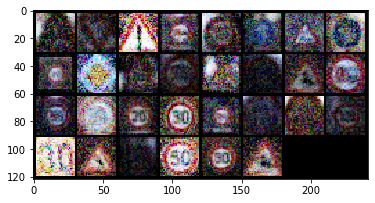

In [22]:
def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    display.display(plt.gcf())
    display.clear_output(wait=True)

from time import sleep
from IPython import display

while(True):
    z = Variable(Tensor(np.random.normal(0, 1, (30, 100))))
    gen_imgs = generator(z)
    show(make_grid(gen_imgs.data))
    sleep(4)
